# Transforming the .mp3 files into .png files

This file is dedicated to getting the data needed to perform convolution on the songs for this project.  The process has 2 main parts.  It recognizes the .mp3 file, and using the SoX (Sound Exchange) library takes the song from a .mp3 file and converts it into a static image of the sound waveforms called a spectrogram.  Once all the spectrograms are created, they are sent through another set of functions to create slices of the songs, which are then analyzed.

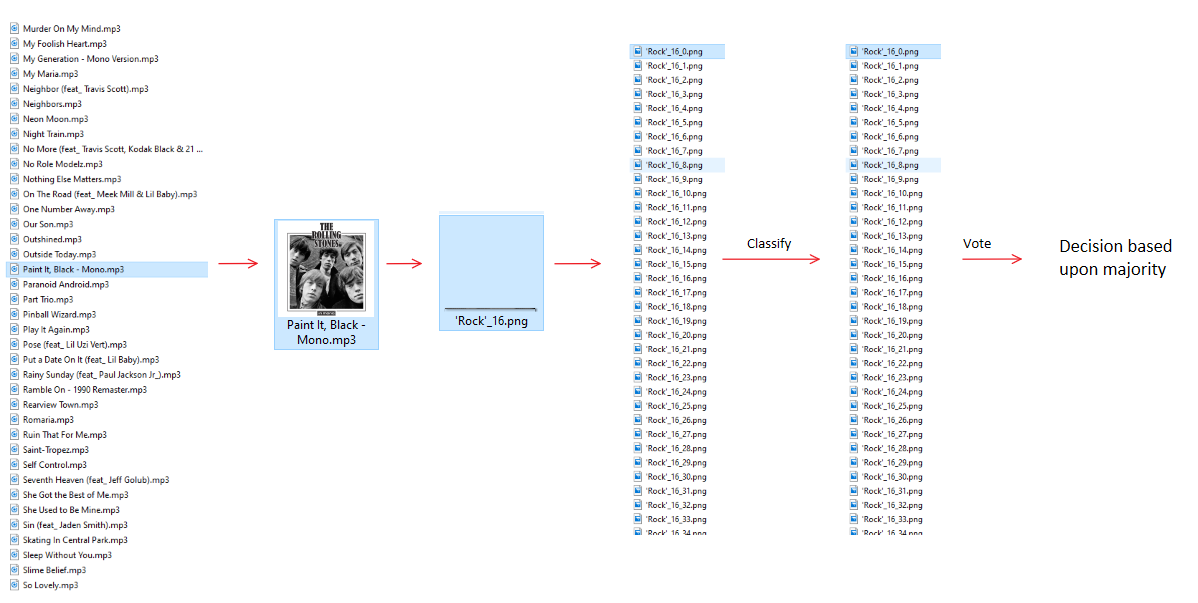

This file was based upon a set of files from stackoverflow, linked below.  This site includes a model and other features that I did not use on the rest of my project.

https://medium.com/@juliendespois/finding-the-genre-of-a-song-with-deep-learning-da8f59a61194#.yhemoyql0

https://github.com/despoisj/DeepAudioClassification

In [5]:
# imports libraries needed for converting the mp3 files to the images slices 
from subprocess import Popen, PIPE, STDOUT
from PIL import Image

import sys
import os
import eyed3

In [6]:
# Constant variables needed for some calculations
size = 128
pixelPerSecond = 50

# All paths where files are loaded from and/or saved
currentPath = os.path.abspath('')
rawDataPath = "Data/Raw/"
slicesPath = "Data/Slices/"
datasetPath = "Data/Dataset/"
spectrogramsPath = "Data/Spectrograms/"
tmpPath = "Data/tmp/"

eyed3.log.setLevel("ERROR")

# Making the file Mono

The following function simply adjusts all the files to be 'mono' or Monaural, which makes there only 1 source of the audio, removing certain effects on audio to have it play from different sources like left/right, for example.

In [7]:
def isMono(filename):
    audiofile = eyed3.load(filename)
    return audiofile.info.mode == 'Mono'

# Getting the Genre for data Labels

This next function looks at the file and gets the assigned genre.  Thanks to an error with downloading my data, all 5 genres were set manually by me to ensure consistency.  I wanted to avoid issues with thinks like 'Rap' vs 'Rap/Hip-Hop' because genres are not really a hard boundary for music anymore.

In [8]:
def getGenre(filename):
    audiofile = eyed3.load(filename)
    if not audiofile.tag.genre:
        return None
    else:
        return audiofile.tag.genre.name.encode('utf-8')

# Creating a Spectrogram

The next 2 functions exist to make a spectrogram from the audio file.  A spectrogram specifically is an image file of the audio's waveforms, and looks something like this:

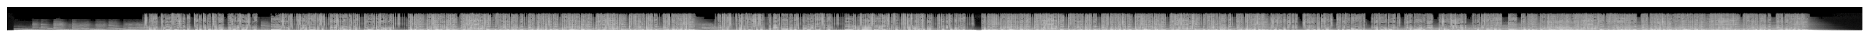
(this is the spectrogram of thank u, next)

The length of the image depends on the length of the song, and we will adjust this more later to make it easier to use.

By getting an image of the song, we can apply convolution to the image and try to identify musical patterns in the waveforms.

In [9]:
def createSpectrogram(filename, newFilename):
    #Create temporary mono track if needed 
    newFilename = newFilename.replace("b", "")
    if isMono(rawDataPath+filename):
        command = "cp \"{}\" \"{}.mp3\"".format(rawDataPath+filename,tmpPath+newFilename)
    else:
        command = "sox \"{}\" \"{}.mp3\" remix 1,2".format(rawDataPath+filename,tmpPath+newFilename)
    p = Popen(command, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=(sys.platform != 'win32'), cwd=currentPath)
    output, errors = p.communicate()
    if errors:
        print(errors)

    #Create spectrogram
    filename.replace(".mp3","")
    command = "sox \"{}.mp3\" -n spectrogram -Y 200 -X {} -m -r -o \"{}.png\"".format(tmpPath+newFilename,pixelPerSecond,spectrogramsPath+newFilename)
    p = Popen(command, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=(sys.platform != 'win32'), cwd=currentPath)
    output, errors = p.communicate()
    if errors:
        print(errors)

    #Remove tmp mono track
    try:
        os.remove("{}.mp3".format(tmpPath+newFilename))
    except OSError as exc:
        print(exc)

In [10]:
   def createSpectrogramsFromAudio():
    genresID = dict()
    files = os.listdir(rawDataPath)
    files = [file for file in files if file.endswith(".mp3")]
    nbFiles = len(files)

    #Create path if not existing
    if not os.path.exists(os.path.dirname(spectrogramsPath)):
        try:
            os.makedirs(os.path.dirname(spectrogramsPath))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
        #Rename files according to genre
    for index,filename in enumerate(files):
        print("Creating spectrogram for file {}/{}...".format(index+1,nbFiles))
        fileGenre = getGenre(rawDataPath+filename)
        genresID[fileGenre] = genresID[fileGenre] + 1 if fileGenre in genresID else 1
        fileID = genresID[fileGenre]
        newFilename = str(fileGenre)+"_"+str(fileID)
        createSpectrogram(filename,newFilename)

# Creating Slices

The following 2 functions will take the newly created spectrogtams, and slice them into nice, usable images for our analysis.  The slices look like the following:

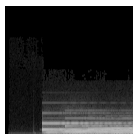

The slices are a 128x128 image, and the amount of them vary depending on the length of the song. A 3 minute song will provide around 70 slices, and in this project the slices range from 60 to 150.

In [11]:
def createSlicesFromSpectrograms(size):
    for filename in os.listdir(spectrogramsPath):
        if filename.endswith(".png"):
            sliceSpectrogram(filename,size)

In [12]:
def sliceSpectrogram(filename,size):
    genre = filename.split("_")[0]

    # Load the full spectrogram
    image = Image.open(spectrogramsPath+filename)

    #Compute approximate number of 128x128 samples
    width, height = image.size
    nbSamples = int(width/size)
    width - size

    #Create path if not existing
    slicePath = slicesPath+"{}/".format(genre);
    if not os.path.exists(os.path.dirname(slicePath)):
        try:
            os.makedirs(os.path.dirname(slicePath))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    
    #For each sample
    for i in range(nbSamples):
        print("Creating slice: ", (i+1), "/", nbSamples, "for", filename)
        #Extract and save 128x128 sample
        startPixel = i*size
        imageTemp = image.crop((startPixel, 1, startPixel + size, size + 1))
        imageTemp.save(slicesPath+"{}/{}_{}.png".format(genre,filename[:-4],i))

# Creating the Images

With all of these functions together, we can finally create the images that will create the dataset needed for the model.  The cells below will create the dataset and has regular print statements to show progress.  This updater is incredibly necessary as it takes a LONG time for one spectrogram to be created and sliced.  I only made the data set once because it took 10 hours to create 249 images.

In [13]:
def createSlicesFromAudio():
    print("Creating spectrograms...")
    createSpectrogramsFromAudio()
    print("Spectrograms created!")

    print("Creating slices...")
    createSlicesFromSpectrograms(size)
    print("Slices created!")

In [ ]:
createSlicesFromAudio()